# CODIGO GENERAL

## 1.1 - LIBRERIAS

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [59]:
# Configurar la visualización de gráficos inline
%matplotlib inline

# 2.O - CSV DENUNCIAS


### 2.1 - IMPORTACION DE CSV

In [60]:
denuncias_path = ('../datos/csv procesados/limpios_denuncias.csv')
df_denuncias = pd.read_csv(denuncias_path)

In [61]:
df_denuncias.sample(3, random_state=4)

,fecha_ingreso,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,...,derivacion3_fecha,derivacion3_judicializa,denunciante_nacionalidad,denunciante_provincia,denunciante_localidad,denunciante_tipo,denunciante_como_conocio_la_linea,denunciante_genero,denunciante_edad_aparente,provincia_indec_id
478,2020-04-17,NaN,505455505,Urgencia,Ciudadano,No,Trata,Grooming,Buenos Aires,Florencio Varela,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0
5620,2023-05-31,14:28,2545751535,Emergencia,Ciudadano,Sí,Trata,"Explotación sexual niñas, niños y adolescentes",Santa Fe,Rosario,...,NaN,NaN,NaN,Santa Fe,NaN,Denunciante - ciudadano,NaN,Mujer,0.0,82.0
1959,2021-04-16,NaN,9494751515,Urgencia,Ciudadano,Sí,Trata,Explotación sexual,Buenos Aires,Ituzaingó,...,NaN,NaN,NaN,NaN,NaN,Denunciante - ciudadano,NaN,Hombre,35.0,6.0


### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [62]:
# Convertir hora_ingreso a hora del día
df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour

# Convertir fecha_ingreso a datetime
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])

# Lista de columnas para convertir a categorías
categorias_cols = ['situacion', 'origen', 'tema', 'provincia', 'dependencia_alta', 
                   'via_ingreso', 'derivacion_institucion', 'derivacion_judicializa', 
                   'denunciante_provincia', 'es_anonima', 'subtema', 'localidad',
                    'denunciante_como_conocio_la_linea']

# Convertir columnas a categorías en una sola línea
df_denuncias[categorias_cols] = df_denuncias[categorias_cols].astype('category')

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_2365/4206414756.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_denuncias['hora_ingreso'] = pd.to_datetime(df_denuncias['hora_ingreso']).dt.hour


In [63]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['derivacion_fecha'] = pd.to_datetime(df_denuncias['derivacion_fecha'])
df_denuncias['derivacion_hora'] = df_denuncias['derivacion_fecha'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['derivacion_anio'] = df_denuncias['derivacion_fecha'].dt.year
df_denuncias['derivacion_mes'] = df_denuncias['derivacion_fecha'].dt.month
df_denuncias['derivacion_dia'] = df_denuncias['derivacion_fecha'].dt.day

df_denuncias  = df_denuncias.drop('derivacion_fecha', axis=1)

In [64]:
# Convierto valores float a int
# Itera a través de las columnas del DataFrame
for column in df_denuncias.columns:
    # Verifica si el tipo de la columna es float o float64
    if df_denuncias[column].dtype in ['float', 'float64']:
        # Encuentra los índices donde los valores no son nulos
        not_null_indices = pd.notna(df_denuncias[column])
        
        # Convierte los valores no nulos a tipo int y reemplaza los valores en el DataFrame original
        df_denuncias.loc[not_null_indices, column] = df_denuncias.loc[not_null_indices, column].astype(int)

In [65]:
# Convertir derivacion_fecha_hora a hora del día
df_denuncias['fecha_ingreso'] = pd.to_datetime(df_denuncias['fecha_ingreso'])
df_denuncias['ingreso_hora'] = df_denuncias['fecha_ingreso'].dt.hour

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_denuncias['ingreso_anio'] = df_denuncias['fecha_ingreso'].dt.year
df_denuncias['ingreso_mes'] = df_denuncias['fecha_ingreso'].dt.month
df_denuncias['ingreso_dia'] = df_denuncias['fecha_ingreso'].dt.day

df_denuncias  = df_denuncias.drop('fecha_ingreso', axis=1)

#### 2.2.2 - VALORES

In [66]:
df_denuncias.isnull().sum()

hora_ingreso                         3168
nro_registro_interno                    0
situacion                              20
origen                                  0
es_anonima                              0
tema                                    0
subtema                                 0
provincia                             471
localidad                             873
dependencia_alta                        0
via_ingreso                             1
derivacion_institucion                409
derivacion_judicializa                409
derivacion2_institucion              4754
derivacion2_fecha                    4754
derivacion2_judicializa              4754
derivacion3_institucion              5892
derivacion3_fecha                    5892
derivacion3_judicializa              5892
denunciante_nacionalidad             4837
denunciante_provincia                2887
denunciante_localidad                5137
denunciante_tipo                      335
denunciante_como_conocio_la_linea 

##### 2.2.2.0 - IMPUTACION GENERAL

In [67]:
#Interpolaciones realizadas por metodo interpolate 'hora_ingreso', 
moda_situacion = df_denuncias['situacion'].mode()[0]
denunciante_genero_moda = df_denuncias['denunciante_genero'].mode()[0]

df_denuncias.fillna(value = {'hora_ingreso':df_denuncias['hora_ingreso'],
                            'situacion': moda_situacion,
                            'provincia': df_denuncias.provincia.bfill(),
                            'localidad': df_denuncias.localidad.bfill(),
                            'denunciante_genero': denunciante_genero_moda},inplace=True)

In [68]:
df_denuncias.columns

Index(['hora_ingreso', 'nro_registro_interno', 'situacion', 'origen',
       'es_anonima', 'tema', 'subtema', 'provincia', 'localidad',
       'dependencia_alta', 'via_ingreso', 'derivacion_institucion',
       'derivacion_judicializa', 'derivacion2_institucion',
       'derivacion2_fecha', 'derivacion2_judicializa',
       'derivacion3_institucion', 'derivacion3_fecha',
       'derivacion3_judicializa', 'denunciante_nacionalidad',
       'denunciante_provincia', 'denunciante_localidad', 'denunciante_tipo',
       'denunciante_como_conocio_la_linea', 'denunciante_genero',
       'denunciante_edad_aparente', 'provincia_indec_id', 'derivacion_hora',
       'derivacion_anio', 'derivacion_mes', 'derivacion_dia', 'ingreso_hora',
       'ingreso_anio', 'ingreso_mes', 'ingreso_dia'],
      dtype='object')

In [69]:
cols_ordenadas = [
    'ingreso_anio', 'hora_ingreso', 'ingreso_mes', 'ingreso_dia', 'via_ingreso', 
    'nro_registro_interno', 'es_anonima', 'situacion', 'origen', 'provincia', 
    'localidad', 'tema', 'subtema', 'dependencia_alta', 'derivacion_institucion', 
    'denunciante_nacionalidad', 'denunciante_provincia', 'denunciante_localidad', 
    'denunciante_tipo', 'denunciante_como_conocio_la_linea', 'denunciante_genero', 
    'denunciante_edad_aparente', 'derivacion_anio', 'derivacion_mes', 'derivacion_dia', 
    'ingreso_hora', 'derivacion_judicializa', 'derivacion2_institucion', 
    'derivacion2_fecha', 'derivacion2_judicializa', 'derivacion3_institucion', 
    'derivacion3_fecha', 'derivacion3_judicializa', 'provincia_indec_id', 
    'derivacion_hora'
]

df_denuncias = df_denuncias[cols_ordenadas]


##### 2.2.2.1 - IMPUTACION AVANZADA

In [70]:
#df_denuncias['hora_ingreso'].interpolate(method='linear', inplace=True)

#### 2.2.3 - CODIFICACION

##### 2.2.3.0 - CATEGORICOS NOMINALES

In [71]:
columnas_categoricas = df_denuncias.select_dtypes(include=['category', 'object'])
columnas_categoricas_nombres =  columnas_categoricas.columns

In [72]:
# Columnas categoricas nominales
df_denuncias_codificados = df_denuncias
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_denuncias_codificados[column] = encoder.fit_transform(df_denuncias_codificados[column].astype(str))

In [73]:
df_denuncias_codificados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5912 entries, 0 to 5911
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ingreso_anio                       5912 non-null   int32  
 1   hora_ingreso                       2744 non-null   float64
 2   ingreso_mes                        5912 non-null   int32  
 3   ingreso_dia                        5912 non-null   int32  
 4   via_ingreso                        5912 non-null   int64  
 5   nro_registro_interno               5912 non-null   int64  
 6   es_anonima                         5912 non-null   int64  
 7   situacion                          5912 non-null   int64  
 8   origen                             5912 non-null   int64  
 9   provincia                          5912 non-null   int64  
 10  localidad                          5912 non-null   int64  
 11  tema                               5912 non-null   int64

##### 2.2.3.1 - CATEGORICOS ORDINALES

In [74]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [75]:
scaler = MinMaxScaler()
df_denuncias_escalados = scaler.fit_transform(df_denuncias_codificados.copy())
df_denuncias_escalados = pd.DataFrame(df_denuncias_escalados, columns = df_denuncias.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [76]:
df_denuncias_escalados.isnull().sum()

ingreso_anio                            0
hora_ingreso                         3168
ingreso_mes                             0
ingreso_dia                             0
via_ingreso                             0
nro_registro_interno                    0
es_anonima                              0
situacion                               0
origen                                  0
provincia                               0
localidad                               0
tema                                    0
subtema                                 0
dependencia_alta                        0
derivacion_institucion                  0
denunciante_nacionalidad                0
denunciante_provincia                   0
denunciante_localidad                   0
denunciante_tipo                        0
denunciante_como_conocio_la_linea       0
denunciante_genero                      0
denunciante_edad_aparente            1293
derivacion_anio                       409
derivacion_mes                    

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [77]:
df_denuncias.describe(include='all')

,ingreso_anio,hora_ingreso,ingreso_mes,ingreso_dia,via_ingreso,nro_registro_interno,es_anonima,situacion,origen,provincia,...,ingreso_hora,derivacion_judicializa,derivacion2_institucion,derivacion2_fecha,derivacion2_judicializa,derivacion3_institucion,derivacion3_fecha,derivacion3_judicializa,provincia_indec_id,derivacion_hora
count,5912.000000,2744.000000,5912.000000,5912.000000,5912.000000,5.912000e+03,5912.000000,5912.000000,5912.000000,5912.000000,...,5912.0,5912.000000,5912.000000,5912.000000,5912.000000,5912.000000,5912.000000,5912.000000,5283.000000,5503.000000
mean,2021.413227,13.630466,6.042287,15.852673,7.819689,5.029537e+09,0.459574,0.760149,16.663227,6.721583,...,0.0,0.981225,20.298038,1041.773512,1.627199,7.992896,19.964479,1.993403,26.454287,14.143376
std,1.061745,5.271945,3.387694,8.861924,1.285355,2.828835e+09,0.498405,0.427029,56.869986,7.491130,...,0.0,0.395995,1.786851,272.730030,0.766666,0.191028,0.695898,0.113943,29.462629,5.335932
min,2020.000000,0.000000,1.000000,1.000000,0.000000,5.050515e+08,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,2021.000000,11.000000,3.000000,8.000000,8.000000,2.545841e+09,0.000000,1.000000,0.000000,0.000000,...,0.0,1.000000,21.000000,1155.000000,2.000000,8.000000,20.000000,2.000000,6.000000,11.000000
50%,2021.000000,14.000000,6.000000,16.000000,8.000000,5.505305e+09,0.000000,1.000000,0.000000,4.000000,...,0.0,1.000000,21.000000,1155.000000,2.000000,8.000000,20.000000,2.000000,6.000000,15.000000
75%,2022.000000,17.000000,9.000000,24.000000,8.000000,7.545455e+09,1.000000,1.000000,0.000000,13.000000,...,0.0,1.000000,21.000000,1155.000000,2.000000,8.000000,20.000000,2.000000,50.000000,18.000000
max,2023.000000,23.000000,12.000000,31.000000,28.000000,9.494948e+09,1.000000,1.000000,307.000000,23.000000,...,0.0,2.000000,23.000000,1155.000000,2.000000,9.000000,20.000000,2.000000,94.000000,23.000000


### 2.3.0 - CORRELACION

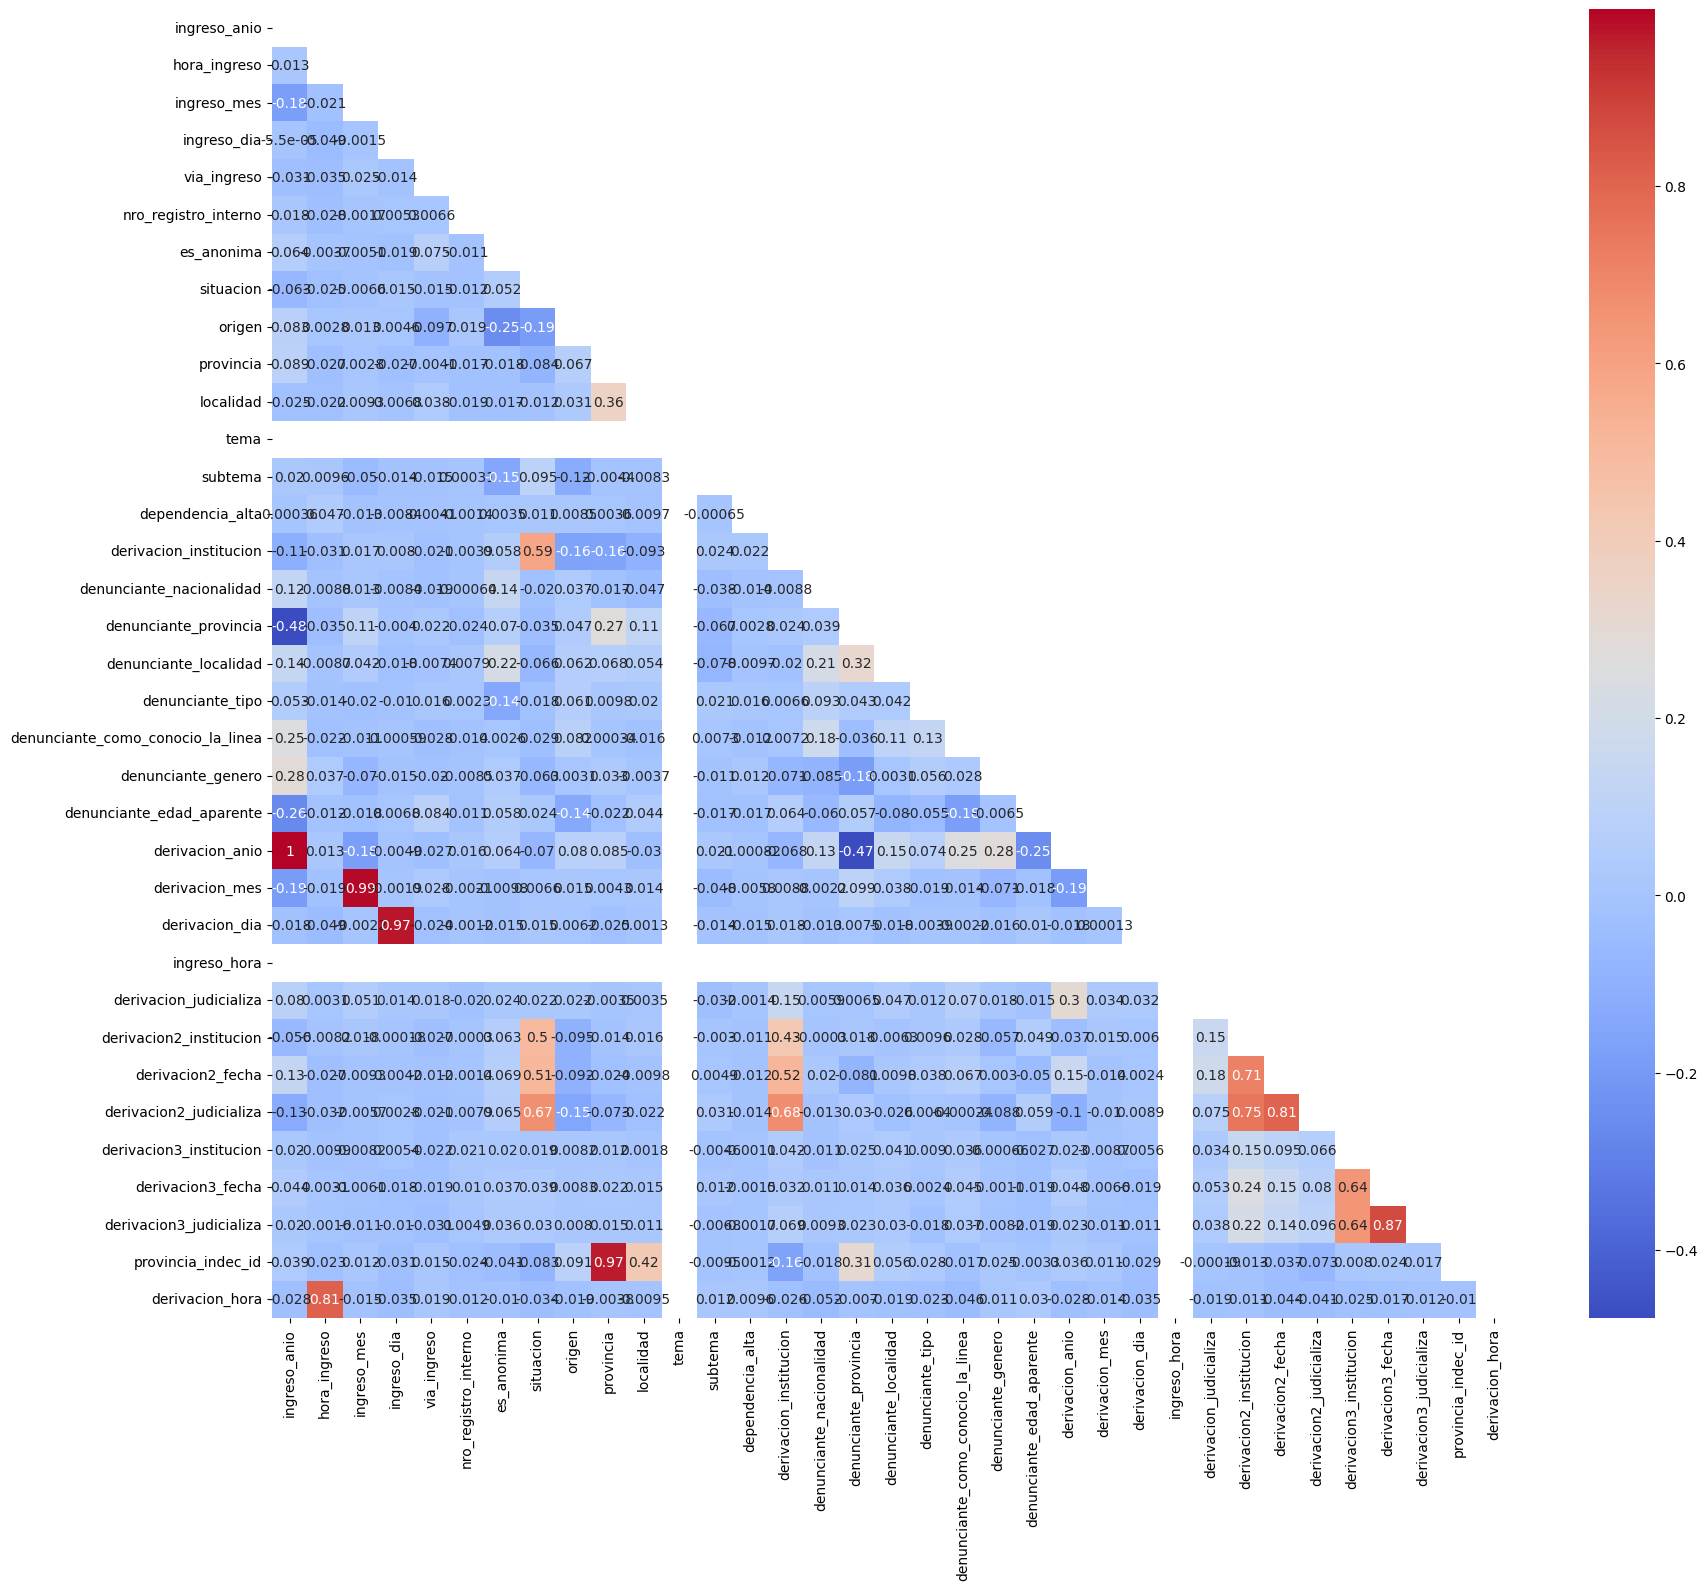

In [78]:
matriz_correlacion = df_denuncias_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
# Crear el mapa de calor con la mitad de la matriz
plt.figure(figsize=(20, 17))  # Ajusta los valores según tus necesidades
sns.heatmap(matriz_correlacion, mask=mascara_espejo, annot=True, cmap='coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [79]:
df_denuncias_codificados.to_csv('../datos/csv procesados/denuncias_codificados.csv', index=False)
df_denuncias_escalados.to_csv('../datos/csv procesados/denuncias_escalados.csv', index=False)
df_denuncias.to_csv('../datos/csv procesados/denuncias.csv', index=False)

# 2.O - CSV ORIENTACIONES


### 2.1 - IMPORTACION DE CSV

In [80]:
path_orientaciones = ('../datos/csv procesados/limpios_orientaciones.csv')
df_orientaciones = pd.read_csv(path_orientaciones)

In [81]:
df_orientaciones.sample(3, random_state=4)

,fecha_ingreso,hora_ingreso,nro_registro_interno,situacion,origen,es_anonima,tema,subtema,provincia,localidad,dependencia_alta,via_ingreso,consultante_nacionalidad,consultante_provincia,consultante_localidad,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente
3080,2022-01-30,19:38,2594759425,Urgencia,Ciudadano,Sí,Covid,Covid,Ciudad Autónoma de Buenos Aires,Buenos Aires,PNR - Línea 145,Línea 145,NaN,Buenos Aires,NaN,NaN,Mujer,50.0
2539,2021-11-16,NaN,3545657515,Urgencia,Ciudadano,No,Salud,Salud mental,NaN,NaN,PNR - Línea 145,Línea 145,NaN,NaN,NaN,NaN,Mujer,0.0
4073,2022-11-02,15:05,505456525,Urgencia,Ciudadano,Sí,Violencia de género,Psicológica,Jujuy,Ciudad Perico,PNR - Línea 145,Línea 145,NaN,Jujuy,NaN,NaN,Mujer,50.0


### 2.2 - COLUMNAS

#### 2.2.1 - TIPOS DE DATOS

In [82]:
# Convertir derivacion_fecha_hora a hora del día
df_orientaciones['fecha_ingreso'] = pd.to_datetime(df_orientaciones['fecha_ingreso'])

# Obtener año, mes y día de derivacion_fecha en una sola línea
df_orientaciones['ingreso_anio'] = df_orientaciones['fecha_ingreso'].dt.year
df_orientaciones['ingreso_mes'] = df_orientaciones['fecha_ingreso'].dt.month
df_orientaciones['ingreso_dia'] = df_orientaciones['fecha_ingreso'].dt.day

df_orientaciones['hora_ingreso'] = pd.to_datetime(df_orientaciones['hora_ingreso']).dt.hour

df_orientaciones  = df_orientaciones.drop('fecha_ingreso', axis=1)

/var/folders/sf/zv8w99hn1570688_wf9y1h280000gn/T/ipykernel_2365/1916780226.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_orientaciones['hora_ingreso'] = pd.to_datetime(df_orientaciones['hora_ingreso']).dt.hour


#### 2.2.2 - VALORES

In [83]:
# Sin simbolos extranios a remplazar o extraer

In [84]:
df_orientaciones.isnull().sum()

hora_ingreso                         2920
nro_registro_interno                    0
situacion                              10
origen                                  0
es_anonima                              0
tema                                    5
subtema                                 5
provincia                            1928
localidad                            2176
dependencia_alta                        0
via_ingreso                           639
consultante_nacionalidad             4355
consultante_provincia                3080
consultante_localidad                4595
consultante_como_conocio_la_linea    4449
consultante_genero                   1080
consultante_edad_aparente            1306
ingreso_anio                            0
ingreso_mes                             0
ingreso_dia                             0
dtype: int64

##### 2.2.2.0 - IMPUTACION GENERAL

In [85]:
#Interpolaciones realizadas por metodo interpolate 'hora_ingreso'
moda_situacion = df_orientaciones['situacion'].mode()[0]


df_denuncias.fillna(value = {'situacion': moda_situacion,
                            'consultante_localidad': df_orientaciones.provincia.bfill(),
                            'consultante_localidad': df_orientaciones.localidad.bfill(),
                            'localidad': df_orientaciones['via_ingreso'].bfill(),
                            'consultante_nacionalidad': 'atencion',
                            'consultante_provincia': 'atencion',
                            'consultante_localidad': 'atencion',
                            'consultante_tipo': 'atencion',
                            'consultante_como_conocio_la_linea': 'atencion',
                            'consultante_genero': 'atencion',
                            'consultante_edad_aparente': 'atencion'
                            },inplace=True)

In [86]:
# Lista con el orden deseado de las columnas
column_order = [
    'ingreso_anio', 'hora_ingreso', 'ingreso_mes', 'ingreso_dia', 'nro_registro_interno',
    'situacion', 'origen', 'provincia', 'localidad', 'tema', 'subtema', 'es_anonima',
    'via_ingreso', 'consultante_nacionalidad', 'consultante_provincia', 'consultante_localidad',
    'consultante_como_conocio_la_linea', 'consultante_genero', 'consultante_edad_aparente'
]

# Reordenar las columnas del DataFrame df_orientaciones
df_orientaciones = df_orientaciones[column_order]


##### 2.2.2.1 - IMPUTACION AVANZADA

In [87]:
df_orientaciones['hora_ingreso'].interpolate(method='linear', inplace=True)

#### 2.2.3 - CODIFICACION

##### 2.2.3.0 - CATEGORICOS NOMINALES

In [88]:
columnas_categoricas = df_orientaciones.select_dtypes(include=['category', 'object'])
columnas_categoricas_nombres =  columnas_categoricas.columns

In [89]:
# Columnas categoricas nominales
df_orientaciones_codificados = df_orientaciones
for column in columnas_categoricas_nombres:
    encoder = LabelEncoder()
    df_orientaciones_codificados[column] = encoder.fit_transform(df_orientaciones_codificados[column].astype(str))

In [90]:
df_orientaciones.head(3)

,ingreso_anio,hora_ingreso,ingreso_mes,ingreso_dia,nro_registro_interno,situacion,origen,provincia,localidad,tema,subtema,es_anonima,via_ingreso,consultante_nacionalidad,consultante_provincia,consultante_localidad,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente
0,2020,NaN,1,1,1584554505,1,0,4,86,34,481,0,11,1,4,36,38,2,25.0
1,2020,NaN,1,2,4584554505,1,0,9,529,28,213,0,11,2,24,216,38,2,NaN
2,2020,NaN,1,2,5584554505,1,0,0,47,34,294,1,11,15,24,216,38,2,NaN


##### 2.2.3.1 - CATEGORICOS ORDINALES

In [91]:
#Columnas categoricas ordinales
# No hay

#### 2.2.4 - ESCALAMIENTO

In [92]:
scaler = MinMaxScaler()
df_orientaciones_escalados = scaler.fit_transform(df_orientaciones_codificados.copy())
df_orientaciones_escalados = pd.DataFrame(df_orientaciones_escalados, columns = df_orientaciones.columns)

#### 2.2.5 - PORCENTAJE DE VALORES

In [93]:
df_orientaciones_escalados.isnull().sum()

ingreso_anio                            0
hora_ingreso                         2920
ingreso_mes                             0
ingreso_dia                             0
nro_registro_interno                    0
situacion                               0
origen                                  0
provincia                               0
localidad                               0
tema                                    0
subtema                                 0
es_anonima                              0
via_ingreso                             0
consultante_nacionalidad                0
consultante_provincia                   0
consultante_localidad                   0
consultante_como_conocio_la_linea       0
consultante_genero                      0
consultante_edad_aparente            1306
dtype: int64

#### 2.2.6 - MEDIDAS DE TENDENCIA CENTRAL

In [94]:
df_orientaciones.describe(include='all')

,ingreso_anio,hora_ingreso,ingreso_mes,ingreso_dia,nro_registro_interno,situacion,origen,provincia,localidad,tema,subtema,es_anonima,via_ingreso,consultante_nacionalidad,consultante_provincia,consultante_localidad,consultante_como_conocio_la_linea,consultante_genero,consultante_edad_aparente
count,5278.000000,2358.000000,5278.000000,5278.000000,5.278000e+03,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,5278.000000,3972.000000
mean,2021.370216,13.461408,5.943729,15.751989,5.052416e+09,0.993748,5.807313,13.118606,344.686434,31.833839,396.057598,0.705570,12.730390,12.803335,16.844070,199.751610,34.355438,4.253884,28.099698
std,1.068667,5.284040,3.389398,8.849941,2.841749e+09,0.100022,29.554570,10.198148,193.856540,5.864739,177.407365,0.835817,5.127914,5.030320,9.784088,47.478404,8.918017,4.489640,24.163614
min,2020.000000,0.000000,1.000000,1.000000,5.050505e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2020.000000,10.000000,3.000000,8.000000,2.555659e+09,1.000000,0.000000,3.000000,124.000000,30.000000,290.000000,0.000000,11.000000,15.000000,6.000000,216.000000,38.000000,2.000000,0.000000
50%,2021.000000,13.000000,6.000000,16.000000,5.505156e+09,1.000000,0.000000,14.000000,405.000000,34.000000,419.000000,0.000000,11.000000,15.000000,24.000000,216.000000,38.000000,2.000000,30.000000
75%,2022.000000,17.000000,9.000000,23.000000,7.555158e+09,1.000000,0.000000,24.000000,529.000000,34.000000,564.000000,1.000000,11.000000,15.000000,24.000000,216.000000,38.000000,10.000000,47.000000
max,2023.000000,23.000000,12.000000,31.000000,9.494949e+09,2.000000,229.000000,25.000000,540.000000,41.000000,745.000000,2.000000,29.000000,15.000000,24.000000,222.000000,44.000000,12.000000,94.000000


### 2.3.0 - CORRELACION

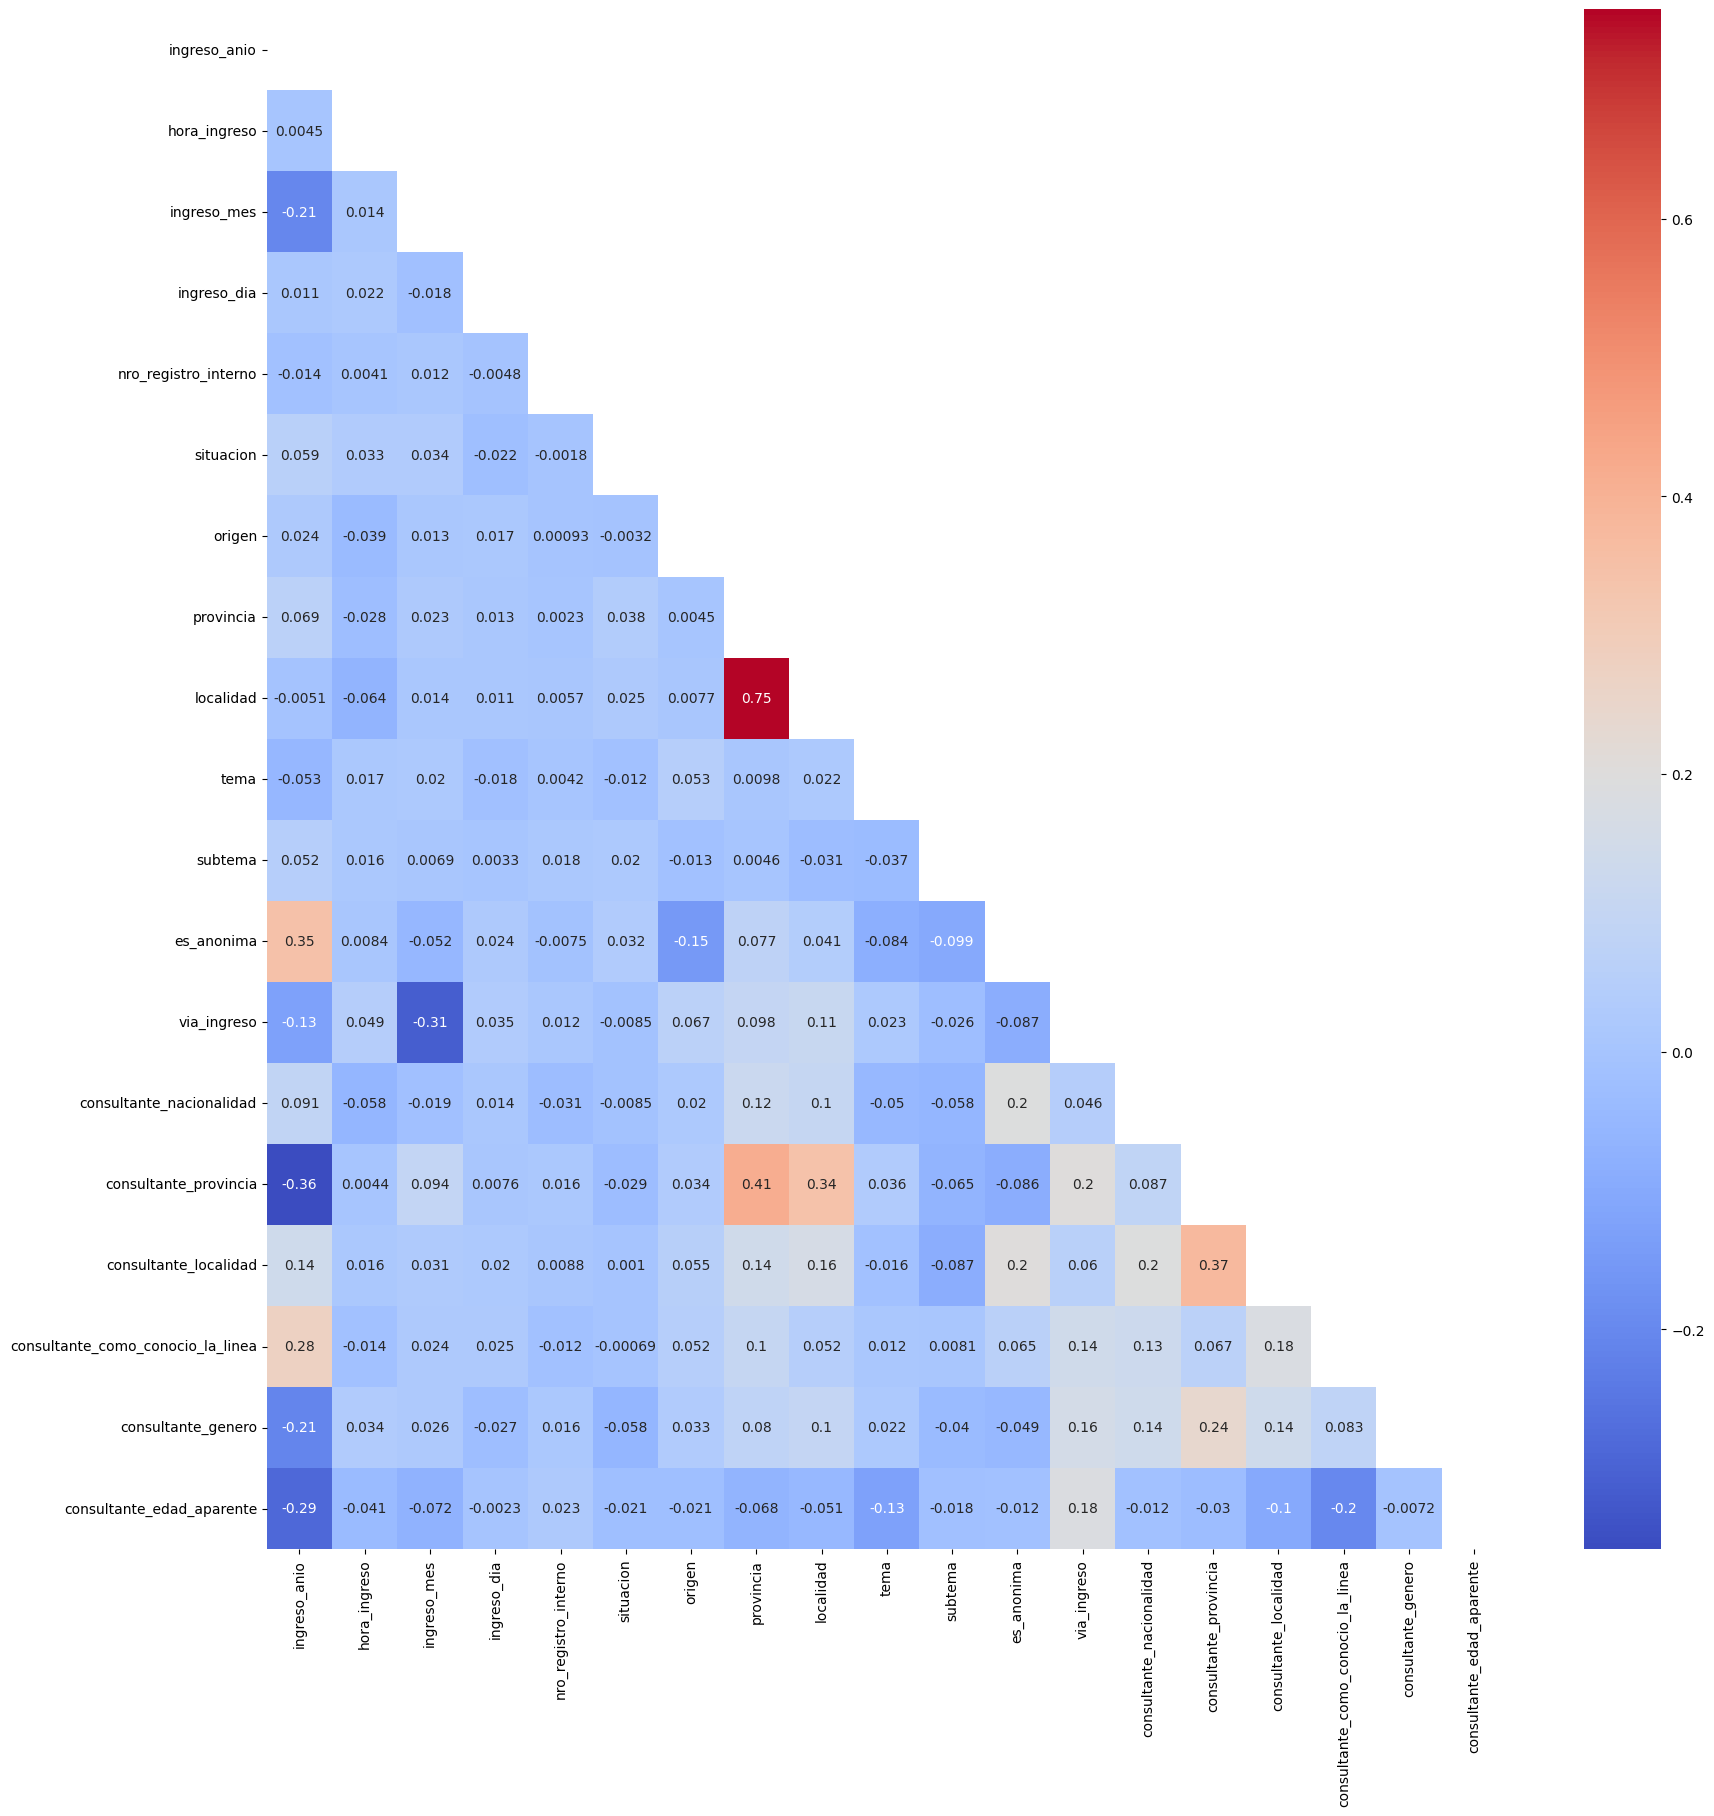

In [95]:
matriz_correlacion = df_orientaciones_escalados.corr()
mascara_espejo = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
plt.figure(figsize=(20, 20))
sns.heatmap(matriz_correlacion, mask = mascara_espejo, annot=True, cmap = 'coolwarm')
plt.show()

### 2.4.0 - ALMACENAMIENTO CSV

In [96]:
df_orientaciones_codificados.to_csv('../datos/csv procesados/orientacion_codificados.csv', index=False)
df_orientaciones_escalados.to_csv('../datos/csv procesados/orientacion_escalados.csv', index=False)
df_orientaciones.to_csv('../datos/csv procesados/orientacion.csv', index=False)